In [1]:
import sys
import rootpath
sys.path.append(rootpath.detect())
import os

ModuleNotFoundError: No module named 'rootpath'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from testsuite.utilities import dominates
from testsuite.utilities import saf

ModuleNotFoundError: No module named 'testsuite'

In [ ]:
matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
matplotlib.rcParams['font.size'] = 15 ;
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

cmap_va = matplotlib.colors.ListedColormap(['None', 'orange'])
cmap_vb = matplotlib.colors.ListedColormap(['None', 'green'])

In [ ]:
def save_fig(fig, filename):
    d = "./figures/"
    path = os.path.join(d, filename)
    fig.savefig(path+".png", dpi=300, facecolor=None, edgecolor=None, orientation='portrait', 
                pad_inches=0.12)

In [3]:
def volume_a(y, targets, p, rp):
    """
    do elements in y belong to volume a, True if 
        - are dominated by any of targets
        - dominate the reference point
        - are dominated by any of p
    """
    va = np.asarray([dominates(targets, yi) and dominates(xyi, rp) and dominates(p, yi)  for yi in y.flat])
    return va

def volume_b(y, targets, p, rp):
    """
    do elements in y belong to volume b, True if 
        - dominate any of targets
        - are dominated by any of p
    """
    vb = np.asarray([np.any([dominates(yi, t) for t in targets]) and dominates(p, xyi) for yi in y])
    return vb

In [4]:
def image_case(case, ref_volume=False, resolution=200):
    """
    returns figure showing volumes Va and Vb from the case desribed
    by case. 
    
    :param case: dict
        dictionary containing case definition
    :param ref_volume: bool
        If true show the outer volumes of which Va and Vb should be 
        calculated as a fraction. Defaults to false as calculating
        these is slow (due to many dominantion relation checks in
        the Pareto front)
    :param resolution: int
        image resoution, keep low (~50) for speed increase. 
    """

    fig = plt.figure(figsize=[6, 6])
    ax = fig.gca() 
    ax.grid('on')
    ax.axis("scaled")
    ax.set_xticks(range(0,12)) 
    ax.set_yticks(range(0,12)) 
    ax.legend(loc="lower left")
    
    x_lim = ax.get_xlim()
    x = np.linspace(0,x_lim[1], resolution)
    y_lim = ax.get_ylim()
    y = np.linspace(*y_lim, resolution)
    xx, yy = np.meshgrid(x, y)
    xy = np.vstack((xx.flat, yy.flat)).T
    zz = saf(xy, case['p']).reshape(resolution, resolution) 
    
    P_x = x
    P_y = 5/x
    t_ideal = case['target'].min(axis=0)
    t_az = case['target'].max(axis=0)
    
    # generate boolean masks for volumes of interest: Va and Vb
    va = np.asarray([dominates(case['target'], xyi) and dominates(xyi, case['ref_point']) and dominates(case['p'], xyi)  for xyi in xy])
    vb = np.asarray([np.any([dominates(xyi, t) for t in case['target']]) and dominates(case['p'], xyi) for xyi in xy])
    
    if ref_volume:
        va_r = np.asarray([dominates(case['target'], xyi) and dominates(xyi, case['ref_point']) for xyi in xy])
        vb_r = np.asarray([np.any([dominates(pi, xyi) for pi in np.vstack((P_x, P_y)).T]) and np.any([dominates(xyi, t) for t in case['target']]) for xyi in xy])

    
    
    a = ax.get_xlim()
    b = ax.get_ylim()
    vol_a = ax.imshow(va.reshape(resolution,resolution)[::-1, :], alpha=0.3, extent=[0, 11, 0, 11], cmap=cmap_va)
    vol_b = ax.imshow(vb.reshape(resolution,resolution)[::-1, :], alpha=0.3, extent=[*ax.get_xlim(), *ax.get_ylim()], cmap=cmap_vb)
    
    if ref_volume:
        vol_ar = ax.imshow(va_r.reshape(resolution,resolution)[::-1, :], alpha=0.1, extent=[0, 11, 0, 11], cmap=cmap_va)
        vol_br = ax.imshow(vb_r.reshape(resolution,resolution)[::-1, :], alpha=0.1, extent=[0, 11, 0, 11], cmap=cmap_vb)
    
    ax.contour(xx, yy, zz, levels=[0.], colors="C0", alpha=0.5)
    
    
    ax.scatter(*case['p'].T, c="C0", label=r"$\tilde{P}$")
    ax.scatter(*case['target'].T, c="magenta", label=r"$T$")
    ax.scatter(*case['ref_point'], c="C3", label=r"$r$")
    
    ax.scatter(*t_ideal, c="magenta", label=r"$\tilde{t}$", marker="*")
    ax.scatter(*t_az, c="magenta", label=r"$\check{t}$", marker="v")
    
    ax.hlines(t_ideal[1], t_ideal[0], t_az[0], colors="magenta", linestyle="--", alpha=0.2)
    ax.hlines(t_az[1], t_ideal[0], t_az[0], colors="magenta", linestyle="--", alpha=0.2)
    ax.vlines(t_ideal[0], t_ideal[1], t_az[1], colors="magenta", linestyle="--", alpha=0.2)
    ax.vlines(t_az[0], t_ideal[1], t_az[1], colors="magenta", linestyle="--", alpha=0.2)
    
    
    ax.plot(P_x, P_y, c="k", label=r"P")
    handles, labels = ax.get_legend_handles_labels()
    handles += [plt.Line2D([0], [0], c="C0", alpha=0.5)]
    handles += [Patch(facecolor="orange", alpha=0.4), Patch(facecolor="green", alpha=0.4)]
    labels += [r"$A$", r"$V_a$", r"$V_b$"]
    nc = 3
    
    if ref_volume:
        handles += [Patch(facecolor="orange", alpha=0.1), Patch(facecolor="green", alpha=0.1)]
        labels += [r"$V_{ar}$", r"$V_{br}$"]
        
        nc = 4
    
    
    ax.legend(handles, labels, loc="lower left", ncol=nc) 
    
    if ref_volume:
        va_frac = (np.sum(va)/np.sum(va_r)).round(3)
        vb_frac = (np.sum(vb)/np.sum(vb_r)).round(3)
    else:    
        va_frac = (np.sum(va)/len(va)).round(3)
        vb_frac = (np.sum(vb)/len(vb)).round(3)
        
    pos_a = np.vstack(np.where(va.reshape(resolution, resolution))).T.mean(axis=0)/resolution*(np.array([x_lim[1]-x_lim[0], y_lim[1]-y_lim[0]]))
    pos_b = np.vstack(np.where(vb.reshape(resolution, resolution))).T.mean(axis=0)/resolution*(np.array([x_lim[1]-x_lim[0], y_lim[1]-y_lim[0]]))
    
    if ref_volume:
        plt.text(pos_a[1], pos_a[0], fr"$M_a={va_frac}$", c=cmap_va.colors[1])
        plt.text(pos_b[1], pos_b[0], fr"$M_b={vb_frac}$", c=cmap_vb.colors[1])
    else:
        plt.text(pos_a[1], pos_a[0], fr"$V_a={va_frac}$", c=cmap_va.colors[1])
        plt.text(pos_b[1], pos_b[0], fr"$V_b={vb_frac}$", c=cmap_vb.colors[1])
    
    return fig

In [5]:
# def scale(x, low, up):
#     return (x-low)/(up-low)

In [6]:
# define test cases

# single target attained
case_00 = {'ref_point': np.array([10., 10.]),
           'name': 'case_00',
          'target' : np.array([[6., 7.]]),
          'p' : np.array([[1., 7.],
                          [3., 6.],
                          [5., 5.],
                          [7., 4.]]),
          'doh': (12., 4.)
          }

# single target unattained
case_01 = {'ref_point': np.array([10., 10.]),
           'name': 'case_01',
          'target' : np.array([[2., 4.]]),
          'p' : np.array([[1., 7.],
                          [3., 6.],
                          [5., 5.],
                          [7., 4.]]),
          'doh': (39., 0.)
          }

# dual targets, both attained
case_02 = {'ref_point': np.array([10., 10.]),
           'name': 'case_02',
           'target' : np.array([[6., 7.],
                                [8., 5.]
                                ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both unattained
case_03 = {'ref_point': np.array([10., 10.]),
           'name': 'case_03',
           'target' : np.array([[2., 5.],
                                [5., 3.]
                                ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, one unattained, one unattained
case_04 = {'ref_point': np.array([10., 10.]),
           'name': 'case_04',
           'target' : np.array([[2., 5.],
                                [8., 5.]
                                ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, one unattained, one unattained, attained beyond span of t
case_05 = {'ref_point': np.array([10., 10.]),
           'name': 'case_05',
           'target' : np.array([[8., 3.],
                                [2., 9.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both unattained, one beyond span of p
case_06 = {'ref_point': np.array([10., 10.]),
           'name': 'case_06',
           'target' : np.array([[2., 5.],
                                [0.8, 9.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both unattained, overlapping volumes
case_07 = {'ref_point': np.array([10., 10.]),
           'name': 'case_07',
           'target' : np.array([[2., 4.],
                                [3., 3.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both attained, one beyond span of p
case_08 = {'ref_point': np.array([10., 10.]),
           'name': 'case_08',
           'target' : np.array([[6., 7.],
                                [9, 5.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# dual targets, both attained, overlapping volumes 
case_09 = {'ref_point': np.array([10., 10.]),
           'name': 'case_09',
           'target' : np.array([[5., 8.],
                                [6, 7.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

# three targets, one unattained, two unattained, attained beyond span of t
case_10 = {'ref_point': np.array([10., 10.]),
           'name': 'case_10',
           'target' : np.array([[8., 3.],
                                [5., 7.],
                                [2., 9.]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }

case_11 = {'ref_point': np.array([10., 10.]),
           'name': 'case_10',
           'target' : np.array([[4., 9],
                                [6, 8],
                                [8, 7]
                               ]),
           'p' : np.array([[1., 7.],
                           [3., 6.],
                           [5., 5.],
                           [7., 4.]]),
           'doh': (12., 4.)
          }


cases = [case_00,
         case_01,
         case_02,
         case_03,
         case_04,
         case_05,
         case_06,
         case_07,
         case_08,
         case_09,
         case_10,
         case_11]


### Nomenclature 
* $P$: Pareto front
* $\tilde{P}$: Approximation to Pareto front: $\tilde{P} = \{y_i\}^n_{i=1}$
* $A$: attainment front
* $r$: reference point
* $T$: targets: $T = \{t_i\}^{n_t}_{i=1}$
* $\tilde{t}$: target ideal, the $j$th component of $\tilde{t}$ is $$\tilde{t}_j = \min_{u \in T}\{u_j\}$$
* $\check{t}$: target zenith, the $j$th component of $\check{t}$ is $$\check{t}_j = \max_{u \in T}\{u_j\}$$


* $H(Y, r)$: Volume dominated by $Y$ referred to $r$

### Volume Definitions

The following line doesn't really make sense because you can't find the intersection of the volume (a scalar) with another scalar. 
$$
V_a = H(T, r) \cap H(\tilde{P}, r)
$$



Perhaps you mean the volume of the region that is dominated by the target set $T$ and is also dominated by the estimated Pareto front.  We then need an extra bit of notation to indicate the region that is dominated by a set $Z$ in objective space.  Define a function to denote that:

$$ 
\mbox{dom}(Z) = \{ u \,|\, \exists z \in Z ~ s.t. ~ z \prec u \}
$$

Then the region that is dominated by the targets and also the estimated Pareto front is:

$$
V_a = H(\mbox{dom}(T) \cap \mbox{dom}(\tilde{P}), r)
$$

This is the yellowy-orange region in the picture below.

Similarly, $V_b$ is probably the meant to be the volume dominated by the estimated Pareto set, but not by the target ideal:

$$ 
V_b = H(\mbox{dom}(\tilde{P}) \setminus \mbox{dom}(\check{t}), r)
$$

This is the green region in the figure.



#### Reference  Volumes

The reference volumes are then defined by the best that can be attained.  That is, when the estimated Pareto front coincides with the true Pareto front.  Thus

$$
V_{ar} = V_a = H(\mbox{dom}(T) \cap \mbox{dom}(P), r)
$$

Since $V_b$ measures the amount of objective spacee that the estimated Pareto front has dominated that was not dominated by the target ideal, the normalising region should be the volume that is domeinated by the true Pareto that is not dominated by the target ideal.  

$$
V_{br} = H(\mbox{dom}(P) \setminus \mbox{dom}(\check{t}), r)
$$

However, this is not what is drawn in light green and I'm not sure whether this is what we really want.  


### Relative Hypervolume Scores 
$$
M_a = \frac{V_a}{V_{ar}} = \frac{H(T, r) \cap H(\tilde{P}, r)}{H(T, r)}
$$

$$
M_b = \frac{V_b}{V_{br}} = \frac{H(P, T) \cap H(\tilde{P}, T)}{H(P, T)} 
$$

where
$$
H(P, T) = \{(P, t_1) \cap (P, t_2) \cap \cdots (P, t_n)\}
$$


<ipython-input-49-c6ae0c1731c0>:34: RuntimeWarning: divide by zero encountered in true_divide
  P_y = 5/x


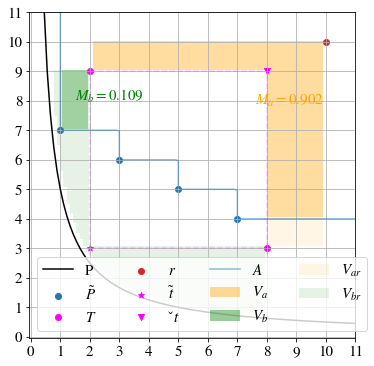

In [72]:
# change case number here
fig = image_case(case_05, True, 100)

In [75]:
# for case in cases:
#     fig = image_case(case, True, 100)
#     save_fig(fig, case['name']);

# Practical calculation  of $M_a$ and $M_b$:
### definitions
* dominated(a, b): find the elements of a which are dominated by at least one element of b  
* nondominated(a, b): find the elements of a which are not dominated by at least one element of b  

###  Monte-Carlo:
##### $M_a$
* draw a large number of random uniform samples ($S$) between $\tilde{t}$ and $r$: $S \gets$  np.random.uniform($\tilde{t}$, r, 1e7)
* reduce $S$ to only those samples which are dominated by at least one of $T$: $S \gets$ dominated($S$, $T$)
* store as $V_{ar}$: $V_{ar} \gets S$
* find the elements of $V_{ar}$ which are dominated by at least one of $\tilde{P}$: $V_a \gets $dominated($V_{ar}$, $\tilde{P}$)
* $M_a = \frac{v_a}{v_{ar}}$

##### $M_b$
* draw a large number of random uniform samples ($S$) between $0$ and $\check{t}$: $S \gets$  np.random.uniform($0$, $\check{t}$, 1e7)
* reduce $S$ to only those which are dominated by an element of $T$ and are not dominated by any of $P$:
$$
S \gets \text{dominated($S$, $T$)}
$$
$$
S \gets \text{nondominated($S$, $P$)}
$$
* store as $V_{br}$: $V_{br} \gets S$
* find the elements of $V_{br}$ which are not dominated by any of $\tilde{P}$: $V_b \gets $nondominated($V_{br}$, $\tilde{P}$)
* $M_b = \frac{v_b}{v_{br}}$

note: calculating $V_{br}$ will be expensive, but only needs to be done once for each problem configuration


###  Exact:
I have given this further thought, and cannot come up with a way to perform the exact calculation without going into writing my own versin of a Fonseca-style computation, summing the volumes of the many hypercubes arsing from the numberous targets in $T$ and attained evaluations in $\tilde{P}$ (which I am not keen to do). Even if We can find some simple method in two objectives, scaling to more objectives will, i think, become very complicated, particularly with regions dominated by different $t$ which overlap. 